In [1]:
# script to make Arkane ScanLog text file for a given species or TS conformer

In [99]:
import os
import sys
import glob
import numpy as np

import ase.atoms
import ase.io.gaussian
import ase.visualize
import ase.optimize

# need this set to represent the RMG molecule and get the rotors
DFT_DIR = os.environ['DFT_DIR']
sys.path.append(DFT_DIR)
sys.path.append(os.environ['DATABASE_DIR'])
import autotst_wrapper
import autotst.reaction
import autotst.species
import database_fun

import rmgpy.constants

import xtb.ase.calculator


import arkane.ess  # just to check our answers

import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
def get_linear_fit(opt_files):
    m = None
    b = None
    if type(opt_files) != list:
        opt_files = [opt_files]
    xtb_energies = []
    m06_energies = []
    for opt_file in opt_files:
        with open(opt_file, 'r') as f:
            frames = ase.io.gaussian.read_gaussian_out(f, slice(None, None))

        for j in range(len(frames)):
            if not frames[j].calc.results or 'forces' not in frames[j].calc.results.keys():
                continue

            m06_energies.append(frames[j].calc.results['energy'])
            atoms = ase.Atoms(frames[j].numbers, frames[j].positions)
            atoms.calc = xtb.ase.calculator.XTB()
            xtb_energies.append(atoms.get_potential_energy())
    if len(xtb_energies) < 2:
        print('Not enough optimization points for a linear fit!')
        return m, b

        # fit a line
    m, b = np.polyfit(xtb_energies, m06_energies, 1)
    fit_energies = m * np.array(xtb_energies) + b
    corr_matrix = np.corrcoef(np.array(m06_energies), fit_energies)
    corr = corr_matrix[0, 1]
    R_sq = corr ** 2
    print(f'{len(xtb_energies)} points')
    print(f'R^2: {R_sq:.5f}')
    
    return m, b

# Build the RMG molecule or reaction from the optimized geometry

### Species Rotors

In [122]:
# Get the rmg species
species_index = 4
rmg_species = database_fun.index2species(species_index)
species_smiles = rmg_species.smiles
conformer_dir = os.path.join(DFT_DIR, 'thermo', f'species_{species_index:04}', 'conformers')
species_file = autotst_wrapper.get_lowest_valid_conformer(conformer_dir)


2025-04-04 09:26:55.708841 Lowest energy conformer is /work/westgroup/harris.se/autoscience/reaction_calculator/dft/thermo/species_0004/conformers/conformer_0000.log


In [123]:
# make the autotst species object
autotst_cf = autotst.species.Conformer(smiles=species_smiles)
with open(species_file, 'r') as f:
    atoms = ase.io.gaussian.read_gaussian_out(f)
    assert not autotst_wrapper.bonds_too_large(None, species_index, atoms=atoms)
    
autotst_cf._ase_molecule = atoms
autotst_cf.update_coords_from(mol_type="ase")
torsions = autotst_cf.get_torsions()
n_rotors = len(torsions)

In [124]:
# species_files = glob.glob(os.path.join(DFT_DIR, 'thermo', f'species_{species_index:04}', '*', '*.log'))
species_files = glob.glob(os.path.join(DFT_DIR, 'thermo', f'species_{species_index:04}', 'conformers', '*.log'))
m, b = get_linear_fit(species_files)

30 points
R^2: 0.98934


In [125]:
# Get both rigid and relaxed energies
rotor_energies = []
relaxed_rotor_energies = []
regular_xtb = []
for rotor_index in range(n_rotors):
    atoms = autotst_cf.get_ase_mol()
#     angles = np.linspace(0, 360, 73)  # every 5 degrees
    angles = np.linspace(0, 360, 21)
    energies = np.zeros(len(angles))
    relaxed_energies = np.zeros(len(angles))
    regular_xtb_energies = np.zeros(len(angles))

    starting_dihedral = atoms.get_dihedral(
        autotst_cf.torsions[rotor_index].atom_indices[0],
        autotst_cf.torsions[rotor_index].atom_indices[1],
        autotst_cf.torsions[rotor_index].atom_indices[2],
        autotst_cf.torsions[rotor_index].atom_indices[3],
    )

    for angle_index in range(len(angles)):
        # Reset dihedral to optimized starting point
        atoms.set_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            starting_dihedral,
            mask=autotst_cf.torsions[rotor_index].mask
        )

        # and rotate to desired increment
        atoms.rotate_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            angles[angle_index],
            mask=autotst_cf.torsions[rotor_index].mask
        )
        atoms.calc = xtb.ase.calculator.XTB()
        regular_xtb_energies[angle_index] = atoms.get_potential_energy()
        energies[angle_index] = m * regular_xtb_energies[angle_index] + b
        
        
        # now do the optimization
        opt = ase.optimize.BFGS(atoms, logfile=None)
        opt.run(fmax=0.20, steps=1e6)
        relaxed_energies[angle_index] = m * atoms.get_potential_energy() + b
        
    rotor_energies.append(energies)
    relaxed_rotor_energies.append(relaxed_energies)
    regular_xtb.append(regular_xtb_energies)

In [126]:
# assemble the scan energies -- need to check on the units
scan_dir = os.path.join('/work/westgroup/harris.se/rotor_calc/attempted_scan_files', f'species_{species_index:04}')
os.makedirs(scan_dir, exist_ok=True)

for rotor_index in range(len(rotor_energies)):
    scan_logfile = os.path.join(scan_dir, f'rotor_{rotor_index:04}_scan_energies.txt')
    relaxed_scan_logfile = os.path.join(scan_dir, f'rotor_{rotor_index:04}_relaxed_scan_energies.txt')
    xtb_scan_logfile = os.path.join(scan_dir, f'rotor_{rotor_index:04}_plain_xtb_scan_energies.txt')
    lines = [
        'Angle (degrees)\t\tEnergy (kJ/mol)\n',
    ]
    lines_relaxed = [
        'Angle (degrees)\t\tEnergy (kJ/mol)\n',
    ]
    lines_xtb = [
        'Angle (degrees)\t\tEnergy (kJ/mol)\n',
    ]
    for j in range(len(angles)):
        if np.isnan(rotor_energies[rotor_index][j]):
            continue
        energy_kJ_mol = rmgpy.constants.Na * rmgpy.constants.e * rotor_energies[rotor_index][j] / 1000.0  # convert eV to kJ/mol
        lines.append(f'{angles[j]}    {energy_kJ_mol}' + '\n')
    for j in range(len(angles)):
        if np.isnan(relaxed_rotor_energies[rotor_index][j]):
            continue
        energy_kJ_mol = rmgpy.constants.Na * rmgpy.constants.e * relaxed_rotor_energies[rotor_index][j] / 1000.0  # convert eV to kJ/mol
        lines_relaxed.append(f'{angles[j]}    {energy_kJ_mol}' + '\n')
    for j in range(len(angles)):
        if np.isnan(regular_xtb[rotor_index][j]):
            continue
        energy_kJ_mol = rmgpy.constants.Na * rmgpy.constants.e * regular_xtb[rotor_index][j] / 1000.0  # convert eV to kJ/mol
        lines_xtb.append(f'{angles[j]}    {energy_kJ_mol}' + '\n')

    with open(scan_logfile, 'w') as f:
        f.writelines(lines)
    with open(relaxed_scan_logfile, 'w') as f:
        f.writelines(lines_relaxed)
    with open(xtb_scan_logfile, 'w') as f:
        f.writelines(lines_xtb)

In [9]:
def load_scan_energies(rotor_log):
    """
    Extract the optimized energies in J/mol from a log file, e.g. the 
    result of a Gaussian "Scan" quantum chemistry calculation.
    """
    opt_freq = False
    rigid_scan = False

    vlist = []  # The array of potentials at each scan angle
    non_optimized = []  # The array of indexes of non-optimized point

    internal_coord = 'D(' + ','.join(rotor_log.load_scan_pivot_atoms()) + ')'
    angle = []
    # Parse the Gaussian log file, extracting the energies of each
    # optimized conformer in the scan
    with open(rotor_log.path, 'r') as f:
        line = f.readline()
        while line != '':
            # If the job contains a "freq" then we want to ignore the last energy
            if ' Freq' in line and ' Geom=' in line:
                opt_freq = True
            # if # scan is keyword instead of # opt, then this is a rigid scan job
            # and parsing the energies is done a little differently
            if '# scan' in line:
                rigid_scan = True
            # The lines containing "SCF Done" give the energy at each
            # iteration (even the intermediate ones)
            if 'SCF Done:' in line:
                energy = float(line.split()[4])
                # rigid scans will only not optimize, so just append every time it finds an energy.
                if rigid_scan:
                    vlist.append(energy)
            # We want to keep the values of energy that come most recently before
            # the line containing "Optimization completed", since it refers
            # to the optimized geometry
            if 'Optimization completed' in line:
                vlist.append(energy)
            # In some cases, the optimization cannot converge within the given steps.
            # Then, the geometry is not optimized. we need to exclude these values.
            if 'Optimization stopped' in line:
                non_optimized.append(len(vlist))
                vlist.append(energy)
            # Read the optimized angle from optimized parameters
            if internal_coord in line and 'Scan' not in line:
                # EXAMPLE:
                # ! D9    D(1,2,3,15)            42.4441         -DE/DX =    0.0                 !
                angle.append(float(line.strip().split()[3]))

            line = f.readline()
    return vlist, angle

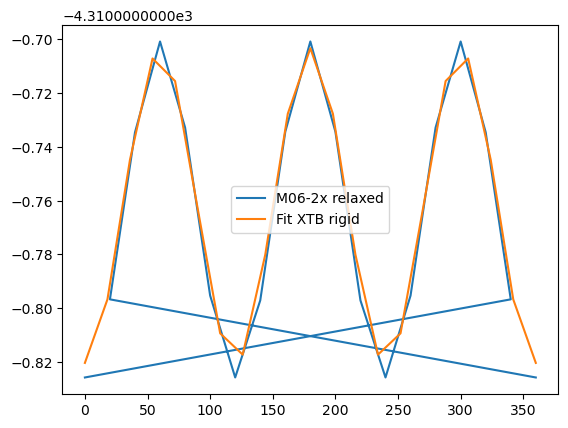

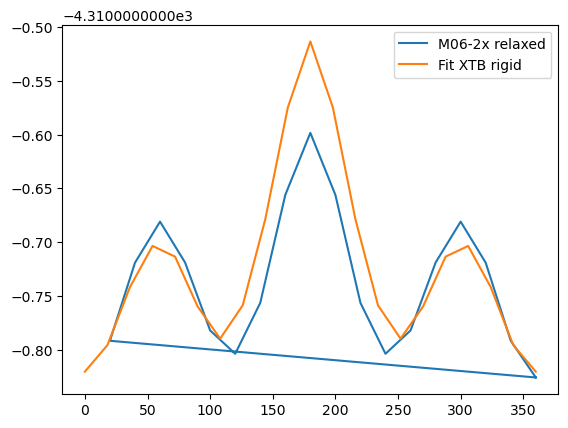

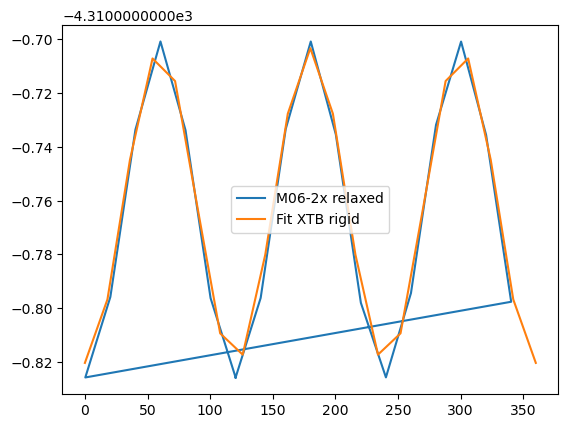

In [10]:
# Grab the actual rotor calcs for comparison (these are relaxed so it's not apples to apples)
for rotor_index in range(len(rotor_energies)):
    actual_rotor_file = os.path.join(DFT_DIR, 'thermo', f'species_{species_index:04}', 'rotors', f'rotor_{rotor_index:04}.log')
    
    rotor_log = arkane.ess.ess_factory(actual_rotor_file)
    vlist, angle = load_scan_energies(rotor_log)
    plt.plot(np.array(angle) + 180, np.array(vlist) * 27.2114, label='M06-2x relaxed')  # convert Ha to eV
    plt.plot(angles, rotor_energies[rotor_index], label='Fit XTB rigid')
    plt.legend()
    plt.show()

### TS Rotors

In [11]:
# Get the rmg species
# reaction_index = 714
reaction_index = 213
direction = 'forward'
rmg_reaction = database_fun.index2reaction(reaction_index)
reaction_smiles = database_fun.reaction_index2smiles(reaction_index)

conformer_dir = os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', 'overall')
reaction_file = autotst_wrapper.get_lowest_valid_ts(conformer_dir)


ERROR:root:d23 distance is too large, it was measured at 1.4618824332770401 Å when the maximum allowable distance is 1.3220242708333334 Å.
ERROR:root:Distance between reacting atoms is too big, we cannot validate this TS through vibrational analysis.


2025-04-04 08:13:16.292269 TS is valid
2025-04-04 08:13:16.297601 Verifying bond counts for reaction 213


In [12]:
reaction = autotst.reaction.Reaction(label=reaction_smiles)  # going back to this even though it's not dependable
reaction.ts[direction][0]._ase_molecule = autotst_wrapper.get_gaussian_file_geometry(reaction_file)
reaction.ts[direction][0].update_coords_from(mol_type="ase")
autotst_cf = reaction.ts[direction][0]
torsions = autotst_cf.get_torsions()
n_rotors = len(torsions)

In [14]:
reaction_files = glob.glob(os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', '*', '*.log'))
# reaction_files = glob.glob(os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', 'overall', '*.log'))
reaction_files += glob.glob(f'/scratch/harris.se/guassian_scratch/rotor_calcs/reaction_{reaction_index:06}/rotor_*/*.log')
m, b = get_linear_fit(reaction_files)

682 points
R^2: 0.58168


In [15]:
autotst_cf.torsions

[<Torsion "(9, 0, 1, 4)">,
 <Torsion "(4, 2, 3, 7)">,
 <Torsion "(3, 2, 4, 1)">,
 <Torsion "(0, 1, 4, 2)">]

In [16]:
rotor_energies = []
for rotor_index in range(n_rotors):
    atoms = autotst_cf.get_ase_mol()
    angles = np.linspace(0, 360, 73)  # every 5 degrees
#     angles = np.linspace(0, 360, 21)  # every 5 degrees
    energies = np.zeros(len(angles))

    starting_dihedral = atoms.get_dihedral(
        autotst_cf.torsions[rotor_index].atom_indices[0],
        autotst_cf.torsions[rotor_index].atom_indices[1],
        autotst_cf.torsions[rotor_index].atom_indices[2],
        autotst_cf.torsions[rotor_index].atom_indices[3],
    )

    for angle_index in range(len(angles)):
        # Reset dihedral to optimized starting point
        atoms.set_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            starting_dihedral,
            mask=autotst_cf.torsions[rotor_index].mask
        )

        # and rotate to desired increment
        atoms.rotate_dihedral(
            autotst_cf.torsions[rotor_index].atom_indices[0],
            autotst_cf.torsions[rotor_index].atom_indices[1],
            autotst_cf.torsions[rotor_index].atom_indices[2],
            autotst_cf.torsions[rotor_index].atom_indices[3],
            angles[angle_index],
            mask=autotst_cf.torsions[rotor_index].mask
        )
        atoms.calc = xtb.ase.calculator.XTB()
        energies[angle_index] = m * atoms.get_potential_energy() + b
    rotor_energies.append(energies)

In [17]:
# # Grab the actual rotor calcs for comparison (these are relaxed so it's not apples to apples)

# for rotor_index in range(len(rotor_energies)):
#     actual_rotor_file = os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', 'rotors', f'rotor_{rotor_index:04}.log')
    
#     with open(actual_rotor_file, 'r') as f:
#         frames = ase.io.gaussian.read_gaussian_out(f, slice(None, None))
        
#         frames = [atoms for atoms in frames if atoms.calc.results]
        
#         m06_energies = np.array([atoms.calc.results['energy'] for atoms in frames])
#         plt.plot(m06_energies - np.min(m06_energies), label='m06')
#         ax = plt.gca()
        
        
#         xs = np.linspace(0, len(frames), len(rotor_energies[rotor_index]))
# #         plt.show()
#         ax.yaxis.get_major_formatter().set_useOffset(False)
#         plt.plot(xs, rotor_energies[rotor_index] - np.min(rotor_energies[rotor_index]), label='Fit XTB rigid')
#         plt.legend()
#         plt.show()

In [18]:
actual_rotor_file

'/work/westgroup/harris.se/autoscience/reaction_calculator/dft/thermo/species_0004/rotors/rotor_0002.log'

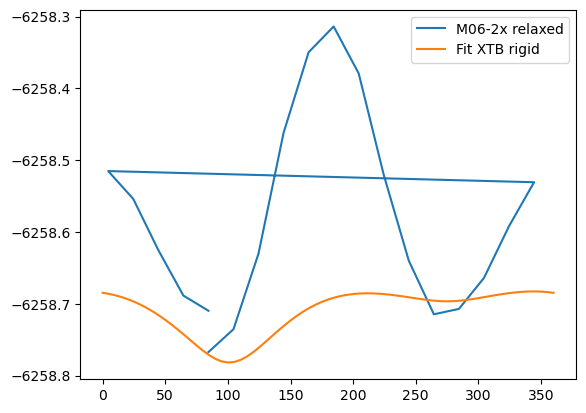

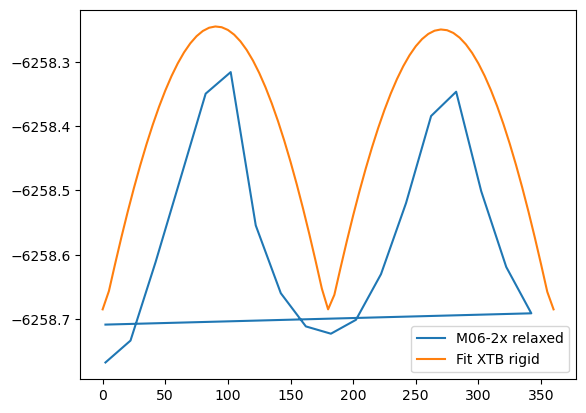

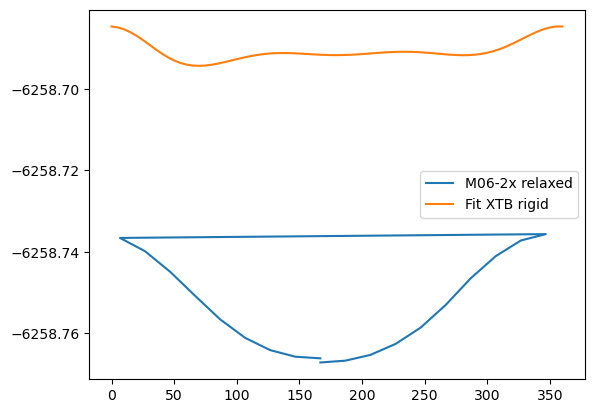

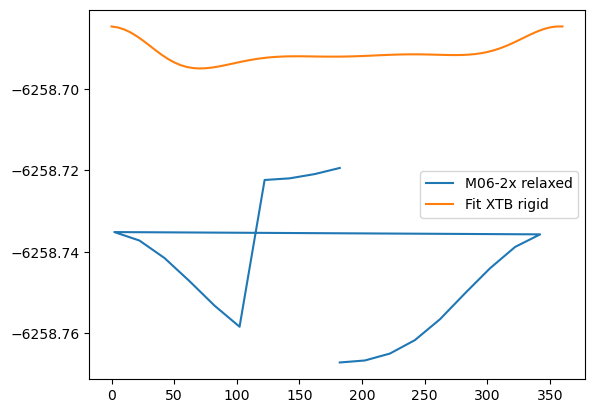

In [19]:
# Grab the actual rotor calcs for comparison (these are relaxed so it's not apples to apples)
for rotor_index in range(len(rotor_energies)):
    actual_rotor_file = os.path.join(DFT_DIR, 'kinetics', f'reaction_{reaction_index:06}', 'rotors', f'rotor_{rotor_index:04}.log')
    try:
        rotor_log = arkane.ess.ess_factory(actual_rotor_file)
    except arkane.exceptions.LogError:
        continue
    vlist, angle = load_scan_energies(rotor_log)
    plt.plot(np.array(angle) + 180, np.array(vlist) * 27.2114, label='M06-2x relaxed')  # convert Ha to eV
    plt.plot(angles, rotor_energies[rotor_index], label='Fit XTB rigid')
    ax = plt.gca()
    ax.yaxis.get_major_formatter().set_useOffset(False)
    plt.legend()
    plt.show()

In [ ]:
# assemble the scan energies -- need to check on the units
for rotor_index in range(len(rotor_energies)):
    my_txt = f'rotor_{rotor_index:04}_scan_energies.txt'
    lines = [
        'Angle (degrees)\t\tEnergy (kJ/mol)\n',
    ]
    for j in range(len(angles)):
        if np.isnan(energies[j]):
            continue
        lines.append(f'{angles[j]}    {rotor_energies[rotor_index][j]}' + '\n')

    with open(my_txt, 'w') as f:
        f.writelines(lines)

In [ ]:
for i in range(len(rotor_energies)):
    plt.plot(rotor_energies[i])
    plt.show()